### Packages

In [1]:
using DynamicalSystems, DifferentialEquations, OrdinaryDiffEq, StaticArrays
using CairoMakie

### Parametres

In [2]:
τ = 0.013; τ_D = 0.15; τ_y = 1.8; τ_F = 1;
α = 1.5; J = 3.07; β = 0.4375
U0 = 0.35; ΔU0 = 0.305
xthr = 0.9; ythr = 0.5
I0 = -1.65;

### function system

In [3]:
U(y) = U0 + ΔU0 / ( 1 + exp( -50 * ( y - ythr ) ) )
σ(x)= 1 / (1 + exp(-20 * (x - xthr)));

In [4]:
function model(u, p ,t)
    E, x, u_, y = u
    τ, α, τ_D, J, U0, ΔU0, τ_y, β, xthr, ythr, I0 = p
    du1 = (-E + α * log( 1 + exp( ( J * u_ * x * E + I0 ) / α ) )) / τ
    du2 = ( 1 - x ) / τ_D - u_ * x * E
    du3 = (U(y) - u_) / τ_F + U(y) * ( 1 - u_ ) * E
    du4 = -y /  τ_y + β * σ(x)
    return SVector(du1, du2, du3, du4)
end;

### initialize system

In [5]:
p = SA[τ, α, τ_D, J, U0, ΔU0, τ_y, β, xthr, ythr, I0]
u0 = SA[0.0, 0.2, 0.1, 0.1]
tspan = (0.0, 500.0);
ds = ContinuousDynamicalSystem(model, u0, p)

4-dimensional continuous dynamical system
 state:       [0.0, 0.2, 0.1, 0.1]
 rule f:      model
 in-place?    false
 jacobian:    ForwardDiff
 parameters:  [0.013, 1.5, 0.15, 3.07, 0.35, …, 1.8, 0.4375, 0.9, 0.5, -1.65]

### Trajectory

In [6]:
tr = trajectory(ds, tspan[2], Ttr = tspan[2]; Δt = 0.001,
                diffeq = (alg = RK4(),  adaptive = false, dense = false, dt = 0.001))

4-dimensional Dataset{Float64} with 500001 points
 11.696    0.683301  0.780958  0.00956833
 12.1502   0.679083  0.78144   0.00956845
 12.618    0.674684  0.781954  0.00956813
 13.0991   0.670106  0.782502  0.00956738
 13.5929   0.665346  0.783084  0.00956623
 14.0988   0.660403  0.7837    0.0095647
 14.6161   0.65528   0.784351  0.00956281
 15.1441   0.649976  0.785038  0.00956059
 15.6818   0.644493  0.78576   0.00955805
 16.2282   0.638834  0.786518  0.00955522
 16.7821   0.633002  0.787312  0.00955213
 17.3423   0.627001  0.788142  0.00954879
 17.9074   0.620837  0.789008  0.00954523
  ⋮                            
  1.54561  0.591829  0.825864  0.00852153
  1.53547  0.59379   0.825483  0.00851774
  1.52571  0.59574   0.825101  0.00851398
  1.5163   0.59768   0.824719  0.00851026
  1.50725  0.599609  0.824338  0.00850659
  1.49855  0.601528  0.823956  0.00850296
  1.49019  0.603437  0.823574  0.00849937
  1.48216  0.605335  0.823193  0.00849583
  1.47447  0.607222  0.822811  0.0084

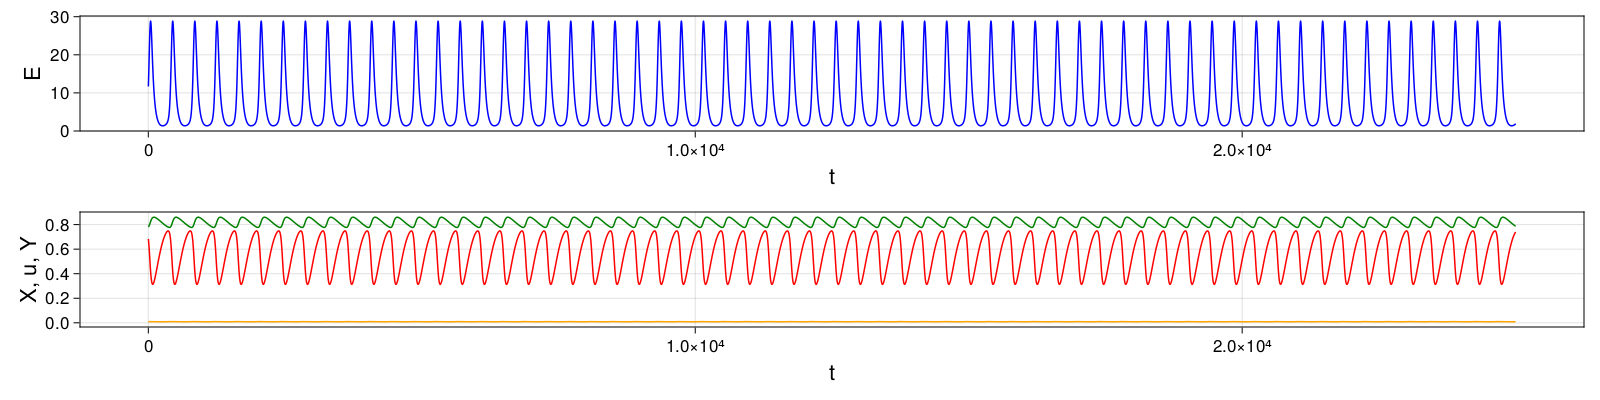

In [7]:
ts, tf = 1, 25000

f = Figure(resolution = (1600, 400))
ax1 = Axis(f[1, 1], xlabel = "t", ylabel = "E", xlabelsize = 22, ylabelsize = 22,xticklabelsize = 17, yticklabelsize = 17)
ax2 = Axis(f[2, 1], xlabel = "t", ylabel = "X, u, Y", xlabelsize = 22, ylabelsize = 22,xticklabelsize = 17, yticklabelsize = 17)

lines!(ax1, tr[ts:tf, 1], color = "blue", label = "E")
lines!(ax2, tr[ts:tf, 2], color = "red", label = "X")
lines!(ax2, tr[ts:tf, 3], color = "green", label = "u")
lines!(ax2, tr[ts:tf, 4], color = "orange", label = "Y")

f

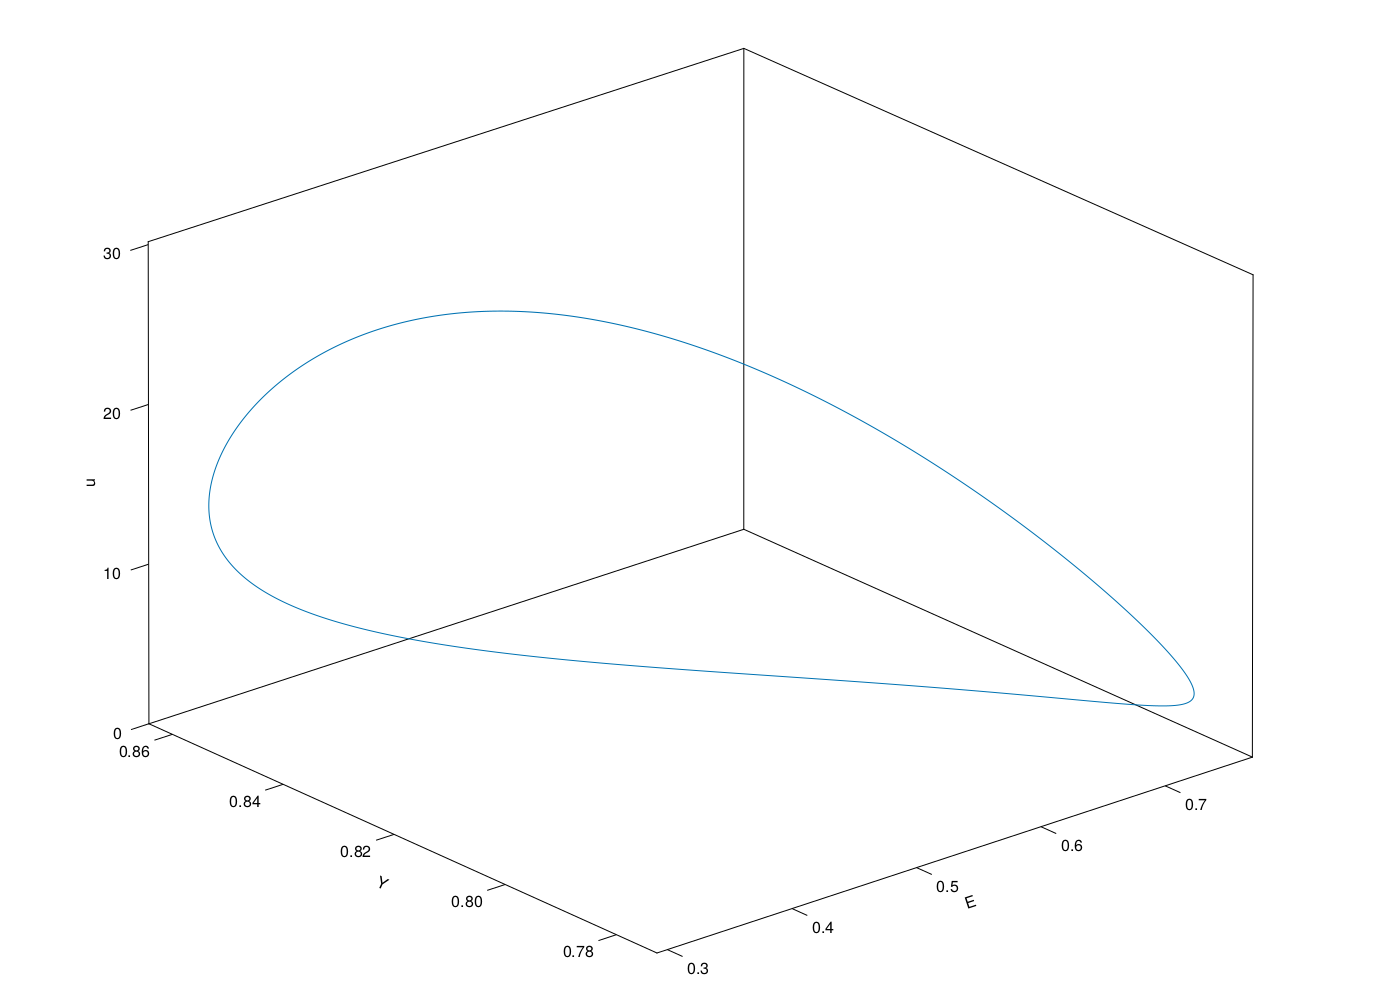

In [8]:
cord1 = 2
cord2 = 3
cord3 = 1
ts, tf = 1, 25000

f = Figure(resolution = (1400, 1000))
ax = Axis3(f[1, 1], xlabel = "E", ylabel = "Y", zlabel = "u")
ax.xgridvisible = false
ax.ygridvisible = false
ax.zgridvisible = false
lines!(tr[ts:tf, cord1], tr[ts:tf, cord2], tr[ts:tf, cord3], linewidth = 1)
f

In [9]:
λλ = lyapunovspectrum(ds, tspan[2], Δt = 1, Ttr = tspan[2]/2; diffeq = (alg = RK4(),  adaptive = false, dt = 0.001) )

4-element Vector{Float64}:
 -0.0035417929583343053
 -0.5555555557751408
 -2.844460775506989
 -3.8311618017154005

### function for 2d map

In [10]:
function check_fp_point(fp, point)
"""
    Проверка на совпадение точки с одним из состояний равновесия.
    
    Алгоритм
        - Находится кол-во состояний равновесия, задаётся некоторое ϵ.
        - Проходимся по всем состояниям равновесия и сравниваем их с точкой с помощью следующего неравенства:
            abs( (E_fp, X_fp, u_fp, Y_fp) - abs( (E_p, X_p, u_p, Y_p) ) ) < ϵ
            то есть, если расстояние между двумя точками по модулю строго меньше, чем ϵ
        - Если неравенство выполняется, то сохраняем индекс, который соответствует этому состоянию равновесия
        - Иначе сохраняем индекс -1
        - По выполнению цикла ищем максимум из всех индексов.
"""
    
    len = length(fp)
    ϵ = [0.001, 0.001, 0.001, 0.001]
    res = zeros(len)
    
    for index in range(1, len, step = 1)
    
        if ( abs.(fp[index] - abs.(point)) ) < ϵ
            res[index] = index
        else
            res[index] = -1

        end
        
    end
    return convert(Int64, maximum(res))
end

function check_eigs_SLE(λλ, eigs)
"""
    Проверка на совпадение SLE (Спектр Ляпуновских показателей) и собственных чисел состояния равновесия
    
    Алгоритм
        - Задаётся ϵ вектор.
        - Если разница между собственными числами состояния равновесия и SLE меньше заданного ϵ вектора, то вернуть true
        - иначе вернуть false
"""
    ϵ = [0.01, 0.01, 0.01, 0.01]
    dif = abs.( sort( real(eigs) ) + (-1) * sort( λλ ) )
    
    if dif < ϵ
        return true # bad
    else
        return false # good
    end
end

function check_start(u0_started = SA[3.3403239669724387, 0.1, 0.1, 0.03677942307955071])

    if flag_start == true
                global u0_loc = u0_started
                flag_start == false
    end
    
end
function output(index_i, index_j, U0_lc, I0_lc, u0_lc)
        println("index i: $index_i"); flush(stdout)
        println("index j: $index_j"); flush(stdout)
        println("U0: $U0_lc;"); flush(stdout)
        println("I0: $I0_lc;"); flush(stdout)
        println("u0: $u0_lc;"); flush(stdout)
end
function separate()
    println(" --------------------- "); flush(stdout)
    println("  "); flush(stdout)
end

separate (generic function with 1 method)

### 2d map

In [174]:
I0_start =  -1.65
I0_finish = -1.5
I0_step = 0.01

U0_start =  0.35
U0_finish = 0.32
U0_step = -0.002

range_U0 = range(U0_start, U0_finish, step = U0_step)
range_I0 = range(I0_start, I0_finish, step = I0_step)

array_u0 = zeros(length(range_U0), length(range_I0), 4 )
array_SLE = zeros(length(range_U0), length(range_I0), 4 );

In [175]:
length(range_U0), length(range_I0)

(16, 16)

In [176]:
for (index_i, U0_lc) in enumerate(range_U0)
    
    if index_i == 1
        global u0_lc = SA[0.0, 0.2, 0.1, 0.1]
    end
            
    output(index_i, 1, U0_lc, I0_start, u0_lc)
    
    p_loc = SA[τ, α, τ_D, J, U0_lc, ΔU0, τ_y, β, xthr, ythr, I0_start]
    ds_loc = ContinuousDynamicalSystem(model, u0_lc, p_loc)

    tr_loc = trajectory(ds_loc, tspan[2], Ttr = tspan[2]; Δt = 0.001, diffeq = (alg = RK4(),  adaptive = false, dense = false, dt = 0.001))
    u0_lc = tr_loc[end, :]
    array_u0[1, index_i, :] = u0_lc
    
    println("last point: $u0_lc");flush(stdout)
    
    random_dot = tr_loc[300000, :]
    println("random point: $random_dot")
    
    λλ = lyapunovspectrum(ds_loc, tspan[2], Δt = 1, Ttr = tspan[2]/2;
                            diffeq = (alg = RK4(),  adaptive = false, dt = 0.001) )
    array_SLE[1, index_i, :] = λλ
    
    println("λλ: $λλ;")
    separate()
end

index i: 1
index j: 1
U0: 0.35;
I0: -1.65;
u0: [0.0, 0.2, 0.1, 0.1];
last point: [1.4532726406060006, 0.6128188288248325, 0.8216678336611694, 0.00848216076958664]
random point: [5.053001361489919, 0.7382969896887166, 0.7769133749430952, 0.009433415783485957]
λλ: [-0.0035417929583343053, -0.5555555557751408, -2.844460775506989, -3.8311618017154005];
 --------------------- 
  
index i: 2
index j: 1
U0: 0.348;
I0: -1.65;
u0: [1.4532726406060006, 0.6128188288248325, 0.8216678336611694, 0.00848216076958664];
last point: [1.4882088263735032, 0.7073439319627065, 0.7983549637423425, 0.008466252874388009]
random point: [28.809896960589644, 0.41591319626860096, 0.824783173113024, 0.009402768955435762]
λλ: [-0.006663277524773389, -0.555555556119541, -2.845750754125723, -3.8317415233625045];
 --------------------- 
  
index i: 3
index j: 1
U0: 0.346;
I0: -1.65;
u0: [1.4882088263735032, 0.7073439319627065, 0.7983549637423425, 0.008466252874388009];
last point: [2.8864559883877328, 0.748544170484360

In [177]:
range_I0_new = range(I0_start, I0_finish, step = I0_step)

for (index_i, U0_lc) in enumerate(range_U0)
    

        for (index_j, I0_lc) in enumerate(range_I0_new)
            
            if index_j == 1
                continue
            end
            if index_j == 2
                global u0_lc = array_u0[index_j - 1, index_i, :]
            end
            
            output(index_i, index_j, U0_lc, I0_lc, u0_lc)
            p_loc = SA[τ, α, τ_D, J, U0_lc, ΔU0, τ_y, β, xthr, ythr, I0_lc]
    
            ds_loc = ContinuousDynamicalSystem(model, u0_lc, p_loc)

            tr_loc = trajectory(ds_loc, tspan[2], Ttr = tspan[2]; Δt = 0.001, diffeq = (alg = RK4(),  adaptive = false, dense = false, dt = 0.001))
            u0_lc = tr_loc[end, :]
            println("last point: $u0_lc");flush(stdout)
            array_u0[index_j, index_i, :] = u0_lc
        
            random_dot = tr_loc[300000, :]
    
            println("random point: $random_dot")
            λλ = lyapunovspectrum(ds_loc, tspan[2], Δt = 1, Ttr = tspan[2]/2;
                            diffeq = (alg = RK4(),  adaptive = false, dt = 0.001) )
            array_SLE[index_j, index_i, :] = λλ
    
            println("λλ: $λλ;")
            separate()
        end

    
end

index i: 1
index j: 2
U0: 0.35;
I0: -1.64;
u0: [1.4532726406060006, 0.6128188288248325, 0.8216678336611694, 0.00848216076958664];
last point: [1.4615151396367503, 0.6726613234978973, 0.8082100455537441, 0.007157237967184155]
random point: [24.38152157287174, 0.5302503381768814, 0.8048417327210592, 0.008058324014045614]
λλ: [-0.006622482499418771, -0.5555555559429227, -2.560493866909026, -3.558441412861049];
 --------------------- 
  
index i: 1
index j: 3
U0: 0.35;
I0: -1.63;
u0: [1.4615151396367503, 0.6726613234978973, 0.8082100455537441, 0.007157237967184155];
last point: [6.134674464211448, 0.38394213303349606, 0.8580097244027246, 0.006188367374447492]
random point: [11.44866785055914, 0.6708842445141351, 0.7873045697244907, 0.006608564705669698]
λλ: [-0.0015016227687328005, -0.5555555556147131, -1.983247133080294, -3.468370089992704];
 --------------------- 
  
index i: 1
index j: 4
U0: 0.35;
I0: -1.62;
u0: [6.134674464211448, 0.38394213303349606, 0.8580097244027246, 0.006188367374

  
index i: 2
index j: 6
U0: 0.348;
I0: -1.6;
u0: [9.75176272874817, 0.4449751534725522, 0.8527118119441437, 8.788332786001085e-5];
last point: [9.775871624283939, 0.4442840363676032, 0.8529928973133337, 8.667706404168188e-5]
random point: [9.775871624283939, 0.4442840363676032, 0.8529928973133337, 8.667706404168188e-5]
λλ: [-0.5555555555685915, -1.395958596234977, -1.4000834107397329, -4.190766587685224];
 --------------------- 
  
index i: 2
index j: 7
U0: 0.348;
I0: -1.59;
u0: [9.775871624283939, 0.4442840363676032, 0.8529928973133337, 8.667706404168188e-5];
last point: [9.799881209871753, 0.4435978066679343, 0.8532717606223785, 8.549571101906653e-5]
random point: [9.799881209871753, 0.4435978066679343, 0.8532717606223785, 8.549571101906653e-5]
λλ: [-0.5555555555685913, -1.4604179231292327, -1.4635908572963736, -4.201176917053662];
 --------------------- 
  
index i: 2
index j: 8
U0: 0.348;
I0: -1.58;
u0: [9.799881209871753, 0.4435978066679343, 0.8532717606223785, 8.549571101906653e

  
index i: 3
index j: 10
U0: 0.346;
I0: -1.56;
u0: [9.847608842210509, 0.4422396936557301, 0.8538229710378552, 8.320495157120142e-5];
last point: [9.871329980745195, 0.44156765756863614, 0.854095390643789, 8.209421482539893e-5]
random point: [9.871329980745195, 0.44156765756863614, 0.854095390643789, 8.209421482539893e-5]
λλ: [-0.5555555555685866, -1.6527055826336712, -1.651238375907539, -4.232045071627318];
 --------------------- 
  
index i: 3
index j: 11
U0: 0.346;
I0: -1.55;
u0: [9.871329980745195, 0.44156765756863614, 0.854095390643789, 8.209421482539893e-5];
last point: [9.894957995870078, 0.4409002031902562, 0.8543657332607749, 8.100572602027987e-5]
random point: [9.894957995870078, 0.4409002031902562, 0.8543657332607749, 8.100572602027987e-5]
λλ: [-0.5555555555685864, -1.7150780070181384, -1.7142197500549174, -4.242217273166864];
 --------------------- 
  
index i: 3
index j: 12
U0: 0.346;
I0: -1.54;
u0: [9.894957995870078, 0.4409002031902562, 0.8543657332607749, 8.10057260202

  
index i: 4
index j: 14
U0: 0.344;
I0: -1.52;
u0: [9.9419404144189, 0.43957875507047794, 0.8549003223348359, 7.889308365519992e-5];
last point: [9.965297607322807, 0.4389246235325606, 0.8551646340445254, 7.786777809980795e-5]
random point: [9.965297607322807, 0.4389246235325606, 0.8551646340445254, 7.786777809980795e-5]
λλ: [-0.5555555555685849, -1.9058721166869335, -1.8957352696159513, -4.272397230791444];
 --------------------- 
  
index i: 4
index j: 15
U0: 0.344;
I0: -1.51;
u0: [9.965297607322807, 0.4389246235325606, 0.8551646340445254, 7.786777809980795e-5];
last point: [9.988567258247318, 0.4382747979877006, 0.8554269993304489, 7.686241470778498e-5]
random point: [9.988567258247318, 0.4382747979877006, 0.8554269993304489, 7.686241470778498e-5]
λλ: [-0.5555555555685846, -1.9620643704719176, -1.9624233684157144, -4.282348350977351];
 --------------------- 
  
index i: 4
index j: 16
U0: 0.344;
I0: -1.5;
u0: [9.988567258247318, 0.4382747979877006, 0.8554269993304489, 7.686241470778

  
index i: 6
index j: 3
U0: 0.34;
I0: -1.63;
u0: [2.296038366597166, 0.5165198385665917, 0.8396667229906941, 0.007363759824959228];
last point: [27.157489049906456, 0.38043663334906086, 0.83591556469529, 0.006474278711991803]
random point: [1.8396088921591305, 0.7085991682349586, 0.7975123250858709, 0.005958686450545637]
λλ: [-0.0010854700574734414, -0.5555555556145984, -1.9812547372491316, -3.468149014525318];
 --------------------- 
  
index i: 6
index j: 4
U0: 0.34;
I0: -1.62;
u0: [27.157489049906456, 0.38043663334906086, 0.83591556469529, 0.006474278711991803];
last point: [1.7820839109401163, 0.6664813533729692, 0.8099329070680172, 0.0042806262334190775]
random point: [11.565778262363757, 0.6566657402292267, 0.7926897309656906, 0.0048103640468488045]
λλ: [-0.0006303263556176107, -0.5555555557226862, -1.0367342084256201, -3.487913553129288];
 --------------------- 
  
index i: 6
index j: 5
U0: 0.34;
I0: -1.61;
u0: [1.7820839109401163, 0.6664813533729692, 0.8099329070680172, 0.0042

  
index i: 7
index j: 7
U0: 0.338;
I0: -1.59;
u0: [9.775871624283939, 0.4442840363676032, 0.8529928973133337, 8.667706404168188e-5];
last point: [9.799881209871753, 0.4435978066679343, 0.8532717606223785, 8.549571101906653e-5]
random point: [9.799881209871753, 0.4435978066679343, 0.8532717606223785, 8.549571101906653e-5]
λλ: [-0.5555555555685913, -1.4605574909951458, -1.4634512894304619, -4.201176917053661];
 --------------------- 
  
index i: 7
index j: 8
U0: 0.338;
I0: -1.58;
u0: [9.799881209871753, 0.4435978066679343, 0.8532717606223785, 8.549571101906653e-5];
last point: [9.823793093787268, 0.4429163848948449, 0.8535484396183697, 8.433856597357067e-5]
random point: [9.823793093787268, 0.4429163848948449, 0.8535484396183697, 8.433856597357067e-5]
λλ: [-0.5555555555685878, -1.529276590692147, -1.522031906054631, -4.211526005194524];
 --------------------- 
  
index i: 7
index j: 9
U0: 0.338;
I0: -1.57;
u0: [9.823793093787268, 0.4429163848948449, 0.8535484396183697, 8.433856597357067

  
index i: 8
index j: 11
U0: 0.336;
I0: -1.55;
u0: [9.871329980745195, 0.44156765756863614, 0.854095390643789, 8.209421482539893e-5];
last point: [9.894957995870078, 0.4409002031902562, 0.8543657332607749, 8.100572602027987e-5]
random point: [9.894957995870078, 0.4409002031902562, 0.8543657332607749, 8.100572602027987e-5]
λλ: [-0.5555555555685864, -1.7208951425996213, -1.7084026144734328, -4.2422172731668635];
 --------------------- 
  
index i: 8
index j: 12
U0: 0.336;
I0: -1.54;
u0: [9.894957995870078, 0.4409002031902562, 0.8543657332607749, 8.100572602027987e-5];
last point: [9.918494336321942, 0.44023725894722376, 0.8546340328087, 7.993887769064508e-5]
random point: [9.918494336321942, 0.44023725894722376, 0.8546340328087, 7.993887769064508e-5]
λλ: [-0.5555555555685862, -1.7782596709629557, -1.7757609482006096, -4.252332682578198];
 --------------------- 
  
index i: 8
index j: 13
U0: 0.336;
I0: -1.53;
u0: [9.918494336321942, 0.44023725894722376, 0.8546340328087, 7.993887769064508

  
index i: 9
index j: 15
U0: 0.334;
I0: -1.51;
u0: [9.965297607322807, 0.4389246235325606, 0.8551646340445254, 7.786777809980795e-5];
last point: [9.988567258247318, 0.4382747979877006, 0.8554269993304489, 7.686241470778498e-5]
random point: [9.988567258247318, 0.4382747979877006, 0.8554269993304489, 7.686241470778498e-5]
λλ: [-0.5555555555685846, -1.9627472710001521, -1.9617404678874795, -4.282348350977349];
 --------------------- 
  
index i: 9
index j: 16
U0: 0.334;
I0: -1.5;
u0: [9.988567258247318, 0.4382747979877006, 0.8554269993304489, 7.686241470778498e-5];
last point: [10.011750677613644, 0.4376292137144705, 0.8556874488006784, 7.58764658343342e-5]
random point: [10.011750677613644, 0.4376292137144705, 0.8556874488006784, 7.58764658343342e-5]
λλ: [-0.5555555555685813, -2.0235283466306635, -2.0232417157249807, -4.292246643942277];
 --------------------- 
  
index i: 10
index j: 2
U0: 0.332;
I0: -1.64;
u0: [10.820805651686733, 0.6912891937009472, 0.7800812208946457, 0.0095666634

λλ: [0.0026452597753292505, -0.5555555554664856, -1.9838022363655803, -3.4681653246619595];
 --------------------- 
  
index i: 11
index j: 4
U0: 0.33;
I0: -1.62;
u0: [3.506773160677662, 0.7295562992058322, 0.7854619278456085, 0.006373147212382493];
last point: [2.49638097432599, 0.5203772902283281, 0.8402199603493373, 0.004357656750236837]
random point: [1.9272166721905757, 0.6866961626089068, 0.804069662498101, 0.004327172572071251]
λλ: [-0.00208324343758112, -0.5555555556561488, -1.0358878278892296, -3.488020529199079];
 --------------------- 
  
index i: 11
index j: 5
U0: 0.33;
I0: -1.61;
u0: [2.49638097432599, 0.5203772902283281, 0.8402199603493373, 0.004357656750236837];
last point: [9.75176272874817, 0.4449751534725523, 0.8527118119441434, 8.788332786001098e-5]
random point: [9.75176272874817, 0.4449751534725523, 0.8527118119441434, 8.788332786001098e-5]
λλ: [-0.5555555555685925, -1.3353101461123442, -1.332088445030044, -4.180293819724231];
 --------------------- 
  
index i: 11

random point: [9.799881209871753, 0.4435978066679343, 0.8532717606223785, 8.549571101906653e-5]
λλ: [-0.5555555555685913, -1.4604922944388379, -1.4635164859867695, -4.201176917053662];
 --------------------- 
  
index i: 12
index j: 8
U0: 0.328;
I0: -1.58;
u0: [9.799881209871753, 0.4435978066679343, 0.8532717606223785, 8.549571101906653e-5];
last point: [9.823793093787268, 0.4429163848948449, 0.8535484396183697, 8.433856597357067e-5]
random point: [9.823793093787268, 0.4429163848948449, 0.8535484396183697, 8.433856597357067e-5]
λλ: [-0.5555555555685878, -1.529194048617471, -1.5221144481293076, -4.211526005194525];
 --------------------- 
  
index i: 12
index j: 9
U0: 0.328;
I0: -1.57;
u0: [9.823793093787268, 0.4429163848948449, 0.8535484396183697, 8.433856597357067e-5];
last point: [9.847608842210509, 0.4422396936557301, 0.8538229710378552, 8.320495157120142e-5]
random point: [9.847608842210509, 0.4422396936557301, 0.8538229710378552, 8.320495157120142e-5]
λλ: [-0.5555555555685875, -1.

last point: [9.894957995870078, 0.4409002031902562, 0.8543657332607749, 8.100572602027987e-5]
random point: [9.894957995870078, 0.4409002031902562, 0.8543657332607749, 8.100572602027987e-5]
λλ: [-0.5555555555685864, -1.7229474537420744, -1.7063503033309813, -4.242217273166864];
 --------------------- 
  
index i: 13
index j: 12
U0: 0.326;
I0: -1.54;
u0: [9.894957995870078, 0.4409002031902562, 0.8543657332607749, 8.100572602027987e-5];
last point: [9.918494336321942, 0.44023725894722376, 0.8546340328087, 7.993887769064508e-5]
random point: [9.918494336321942, 0.44023725894722376, 0.8546340328087, 7.993887769064508e-5]
λλ: [-0.5555555555685862, -1.7812821296252634, -1.7727384895383012, -4.252332682578196];
 --------------------- 
  
index i: 13
index j: 13
U0: 0.326;
I0: -1.53;
u0: [9.918494336321942, 0.44023725894722376, 0.8546340328087, 7.993887769064508e-5];
last point: [9.9419404144189, 0.43957875507047794, 0.8549003223348359, 7.889308365519992e-5]
random point: [9.9419404144189, 0.4

LoadError: InterruptException:

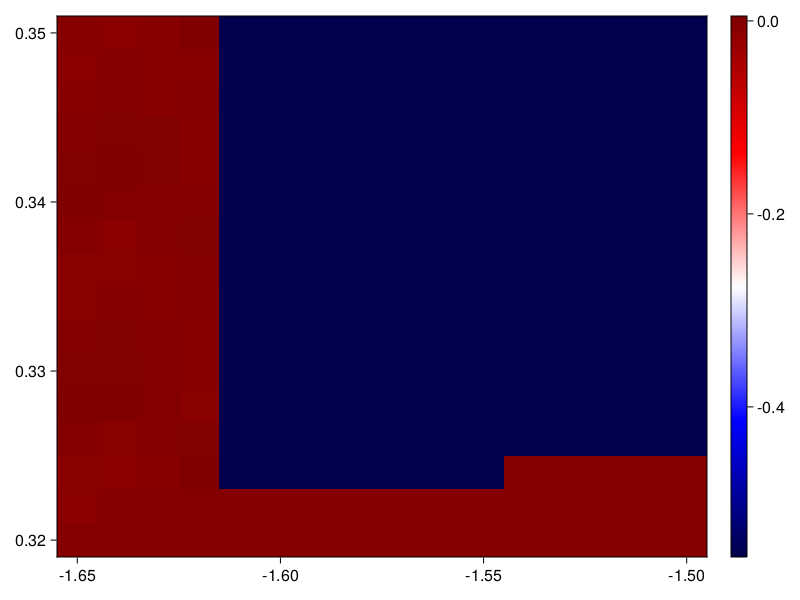

In [178]:
fig, ax, hm = heatmap(range_I0, range_U0, array_SLE[:, :, 1], colormap = :seismic)
Colorbar(fig[:, end+1], hm)

fig

In [179]:
EE_mapcopy = array_SLE[:, :, 1];
EE_mapcopy = [ iszero(x) ? NaN : x for x in array_SLE[:, :, 1] ];

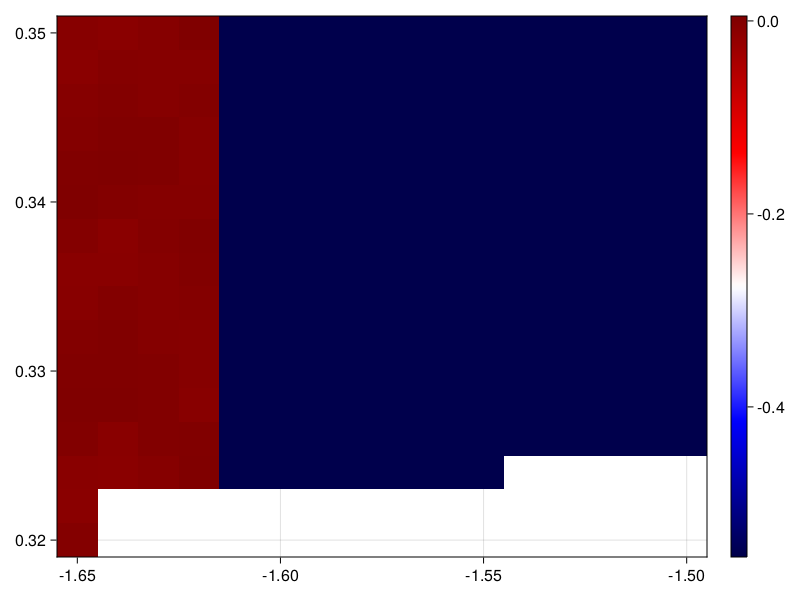

In [180]:
fig, ax, hm = heatmap(range_I0, range_U0, EE_mapcopy, colormap = :seismic)
Colorbar(fig[:, end+1], hm)

fig